In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm
%matplotlib inline

from sklearn.cross_validation import train_test_split

/home/roma/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [3]:
def make_submission(X_test, net, fname="my_submission.csv"):
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [4]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [5]:
train_data = None
test_data = None
encoder = OneHotEncoder()
with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
X = train_data['data']
Y = train_data['target']
Y = np.array(list(map(lambda x : encoder.transform(x), Y)))

#print (X_train [9])
#print (Y_train [9])
#print (Y_train_oh [9])

X_test_no_labels = test_data['data']

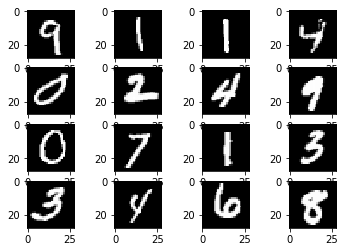

In [6]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [7]:
# Подготовка датасета
mean = np.mean(X, axis=1, keepdims = True)
std = np.std(X, axis=1, keepdims = True)
X = (X - mean) / (std + 0.000001)

mean = np.mean(X_test_no_labels, axis=1, keepdims = True)
std = np.std(X_test_no_labels, axis=1, keepdims = True)
X_test_no_labels = (X_test_no_labels - mean) / (std + 0.000001)


print ('x0 = %s, x1 = %s, x2 = %s' % (Y.shape[0], Y.shape[1], Y.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

print ('X_train_shape0 = %s' % (X_train.shape[0]))
print ('X_train_shape1 = %s' % (X_train.shape[1]))

print ('X_test _shape0 = %s' % (X_test.shape[0]))
print ('X_test _shape1 = %s' % (X_test.shape[1]))

print ('Y_train_shape0 = %s' % (y_train.shape[0]))
print ('Y_test _shape0 = %s' % (y_test.shape[0]))

x0 = 52500, x1 = 10, x2 = 10
X_train_shape0 = 42000
X_train_shape1 = 784
X_test _shape0 = 10500
X_test _shape1 = 784
Y_train_shape0 = 42000
Y_test _shape0 = 10500


In [8]:
# Определение слоев сети
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2/(out_size + in_size))
        self.b = np.zeros(out_size)
        #как здесь инициализируется лучше запомнить и самому так делать
        self.rlambda = rlambda
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.01):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W)
        # рассчитываем градиенты от регуляризатора
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        # возвращаем dx для продолжения алгоритма
        return self.dx

In [9]:
class MaxRelu:
    #вычисляется покомпонетно
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.01):  #lr - для того чтоб интерфейс был унифицирован
        dz[self.x < 0] = 0
        return dz

In [10]:
# нормировка -NPmax

class Softmax: # не облаает изменяемыми параметрами
    
    def forward(self, x):
        self.x = x
        self.frw = np.exp(x) / sum(np.exp(x))
        return self.frw
    
    def backward(self, dz, lr=0.01):
        self.lp  = (np.eye(dz.shape[0]) - self.frw).T
        self.lp2 = self.frw * self.lp
        self.bcw = np.dot (dz, self.lp2)
        return self.bcw

In [11]:
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat  = y_hat
        return - sum(y_true * np.log (y_hat))
    
    def backward(self, dz, lr=0.01):
        return - dz * (self.y_true / self.y_hat)


In [12]:
class Mnistnet:
    
    def __init__ (self):
        self.D1 = Dense (784, 20)
        self.RL = MaxRelu ()
        self.D2 = Dense (20, 10)
        self.SM = Softmax ()
        
    def forward (self, x):
        x = self.D1.forward(x)
        x = self.RL.forward(x)
        x = self.D2.forward(x)
        x = self.SM.forward(x)
        return x
    
    def backward (self, dz, lr=0.01):
        dz = self.SM.backward(dz, lr)
        dz = self.D2.backward(dz, lr)
        dz = self.RL.backward(dz, lr)
        dz = self.D1.backward(dz, lr)
        return dz
    
    

In [16]:
# Здесь процедура обучения
net = Mnistnet()
loss = CrossEntropy()

lRate = 0.01

nEpochs = 10
L_train = [0] * nEpochs
L_test  = [0] * nEpochs
epoch = 0
for iter in tqdm.tqdm_notebook(range(nEpochs)):
    for j in range (X_train.shape[0]):
        y_hat = net.forward (X_train[j])
        L_train[epoch] += loss.forward (y_train[j], y_hat)
        dz = loss.backward (1, lRate)
        net.backward (dz, lRate)
    L_train[epoch] /= X_train.shape[0]
    
    for j in range (X_test.shape[0]):
        y_hat = net.forward (X_test [j])
        L_test [epoch] += loss.forward (y_test [j], y_hat) 
    L_test [epoch] /= X_test.shape[0]
    print ('iter = ', epoch, 'loss_train = ', L_train[epoch], 'loss_test = ', L_test[epoch])
    epoch += 1
    




iter =  0 loss_train =  0.3971977538541699 loss_test =  0.26357084693095695
iter =  1 loss_train =  0.27661667158540965 loss_test =  0.26462256056059336
iter =  2 loss_train =  0.25103088414393476 loss_test =  0.2490334400659056
iter =  3 loss_train =  0.2281578868950704 loss_test =  0.32674179644986706
iter =  4 loss_train =  0.22634064843419985 loss_test =  0.3409687055864822
iter =  5 loss_train =  0.22705112199449515 loss_test =  0.3518142567737882
iter =  6 loss_train =  0.22974502573358427 loss_test =  0.3727190971232698
iter =  7 loss_train =  0.23597462734786737 loss_test =  0.3315728065105524
iter =  8 loss_train =  0.2203296915147355 loss_test =  0.38437290415322256
iter =  9 loss_train =  0.22477678981601995 loss_test =  0.34534300778349897



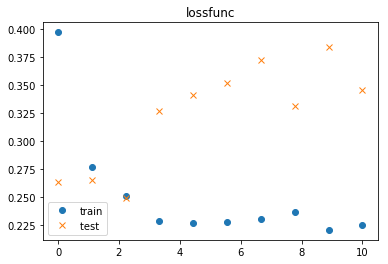

In [17]:
# Здесь необходимо отрисовать графики CrossEntropyLoss для обучающей и валидационной выборок
# plot(L_train, label="train")
# ...

asixX = np.linspace (0, nEpochs, nEpochs)
plt.title ('lossfunc')
plt.plot(asixX, L_train, 'o', label='train')
plt.plot(asixX, L_test , 'x', label='test ')
plt.legend()



In [18]:
# формируем сабмишшен и заливаем его на kaggle
make_submission(X_test_no_labels, net)